**To do**

1. Διόρθωση displ()
2. Γιατί τρώμε το lag
3. Στις πρώτες επαναλήψεις έχω μηδενική μετατόπιση ωστόσο το displ() είναι μη μηδενικό. Εσύ κάνεις round() με αποτέλεσμα αν δεν βγάλεις ακέραια μετατόπιση να ξεχνάς το αποτέλεσμα της i επανάληψης. Aυτά λογικά πρέπει να γίνονται stack.

**$2^o$ ΕΡΓΑΣΤΗΡΙΑΚΟ PROJECT ΣΤΗΝ ΌΡΑΣΗ ΥΠΟΛΟΓΙΣΤΩΝ**

`Αραβανής Τηλέμαχος 03119024`

`Θεοδωρόπουλος Ηλίας 03119858` 

---

In [28]:
#Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import multivariate_normal
from scipy.ndimage import label
from scipy.ndimage import map_coordinates

%matplotlib inline

## Part 1

### 1.1.1

In [2]:
#Load first image of the video 

Im = cv2.imread(".\\cv23_lab2_material\\part1 - GreekSignLanguage\\1.png")
YCrCbIm = cv2.cvtColor(Im, cv2.COLOR_BGR2YCR_CB)

print("Image loaded as: ", type(YCrCbIm))

print("Resolution: ", YCrCbIm.shape)
print("Range: %d - %d " % (np.min(YCrCbIm), np.max(YCrCbIm)))

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (420, 350, 3)
Range: 2 - 240 


In [3]:
# Normalize to [0,1]
YCrCbIm = YCrCbIm.astype(float)/np.max(YCrCbIm)

print("Range: %f - %f " % (np.min(YCrCbIm), np.max(YCrCbIm)))

Range: 0.008333 - 1.000000 


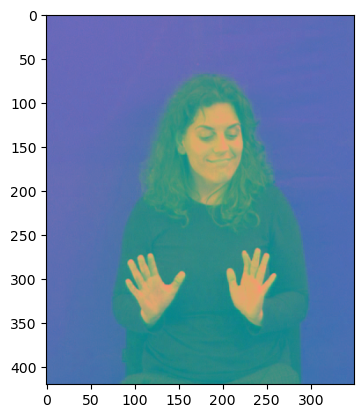

In [4]:
# Show image YCrCb colour space

plt.imshow(YCrCbIm)
plt.show()

In [5]:
# Load skin samples

mat = scipy.io.loadmat('.\\cv23_lab2_material\\part1 - GreekSignLanguage\\skinSamplesRGB.mat')
Skin_samples = mat['skinSamplesRGB']

YCrCb_Skin_samples = cv2.cvtColor(Skin_samples, cv2.COLOR_RGB2YCR_CB)

# Normalize to [0,1]
YCrCb_Skin_samples = YCrCb_Skin_samples.astype(float)/np.max(YCrCb_Skin_samples)

print(YCrCb_Skin_samples.shape)
print("Range: %f - %f " % (np.min(YCrCb_Skin_samples), np.max(YCrCb_Skin_samples)))

(22, 81, 3)
Range: 0.392562 - 1.000000 


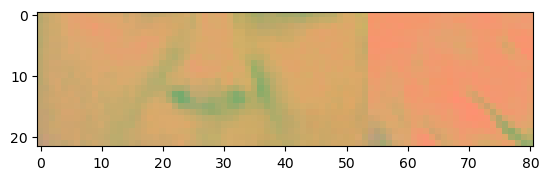

In [6]:
plt.imshow(YCrCb_Skin_samples)
plt.show()

In [7]:
# Estimate 2D-Gaussian according to CrCb samples

CrCb_Skin_samples = YCrCb_Skin_samples[:,:,1:].reshape((22*81,2))

print(CrCb_Skin_samples.shape)

# Maximum Likelihood estimation

mean_ML = np.sum(CrCb_Skin_samples, axis=0)/CrCb_Skin_samples.shape[0]
print(mean_ML)

Std_ML = np.matmul((CrCb_Skin_samples - mean_ML).T,(CrCb_Skin_samples - mean_ML))/CrCb_Skin_samples.shape[0]
print(Std_ML)


(1782, 2)
[0.64895048 0.42673753]
[[ 0.00075415 -0.00020361]
 [-0.00020361  0.00019106]]


In [8]:
def fd(CrCbIm, mean, Std):
    gauss2D = multivariate_normal(mean,Std)
    Skin = (gauss2D.pdf(CrCbIm) > 0.25).astype('uint8')
    
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_big = np.ones((13, 13), np.uint8)
    
    Skin = cv2.morphologyEx(Skin, cv2.MORPH_OPEN, kernel_small, iterations=1) # Opening
    
    Skin = cv2.morphologyEx(Skin, cv2.MORPH_CLOSE, kernel_big, iterations=1) # Closing
    
    Skin, num_features = label(Skin)
    
    Bounding_Boxes = []
    for i in range(1,num_features + 1):
        Bounding_Box = []
        Area = (Skin == i)
        Indeces = np.nonzero(Area)
        Bounding_Box.append(min(Indeces[1]))
        Bounding_Box.append(min(Indeces[0]))
        Bounding_Box.append(max(Indeces[1]) - min(Indeces[1]))
        Bounding_Box.append(max(Indeces[0]) - min(Indeces[0]))
        Bounding_Boxes.append(Bounding_Box)
        
    return Bounding_Boxes
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[118, 100, 123, 131], [206, 266, 52, 85], [92, 272, 65, 77]]
(420, 350, 3)


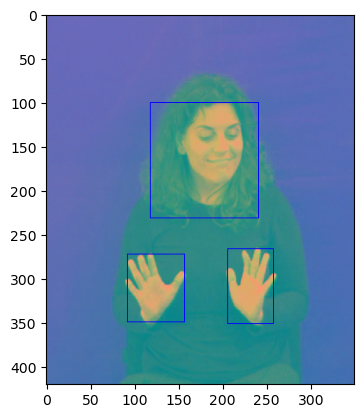

In [9]:
Bounding_Boxes = fd(YCrCbIm[:,:,1:],mean_ML,Std_ML)

print(Bounding_Boxes)

for Bounding_Box in Bounding_Boxes:
    x = Bounding_Box[0]
    y = Bounding_Box[1]
    w = Bounding_Box[2]
    h = Bounding_Box[3]
    YCrCbIm = cv2.rectangle(YCrCbIm, (x,y), (x+w,y+h), (0,0,255), 1)
    
print(YCrCbIm.shape)
    
# Displaying the image 
plt.imshow(YCrCbIm)
plt.show()

### 1.2.1

In [10]:
def Gaussian_Filters_v2(sigma): # from lab1
    n = int(np.ceil(3 * sigma) * 2 + 1)
    Gaussian_1D = cv2.getGaussianKernel(n, sigma)
    Gaussian = Gaussian_1D @ Gaussian_1D.T
    return Gaussian

def lk(I1, I2, features, rho, epsilon, d_x0, d_y0): # Lucas-Kanade algorithm implementation
    
    grad_y, grad_x = np.gradient(I1)
    
    gaussian = Gaussian_Filters_v2(rho)
    
    dx_final = d_x0
    dy_final = d_y0
    
    height, width = I1.shape
    x_0, y_0 = np.meshgrid(np.arange(width), np.arange(height))
    
    for i in range(features.shape[0]):
        
        x = features[i][0][0]
        y = features[i][0][1]
        dx = d_x0[y][x]
        dy = d_y0[y][x]
        u = np.array([[100.0],        
                      [100.0]]) # initializing u with a high value (2x1 vector)
        
        tolerance = 1e-3  # the tolerance level for convergence
        
        prev_dx = 10 # It will enter the while loop
        prev_dy = 10
        
        while (np.abs(dx - prev_dx) > tolerance) or (np.abs(dy - prev_dy) > tolerance): # criterion of convergence
            
            prev_dx = dx
            prev_dy = dy
            
            I1_d = map_coordinates(I1, [y_0 + dy, x_0 + dx], order=1, mode='nearest').reshape(I1.shape)
            a2 = map_coordinates(grad_y, [y_0 + dy, x_0 + dx], order=1, mode='nearest').reshape(I1.shape)
            a1 = map_coordinates(grad_x, [y_0 + dy, x_0+ dx], order=1, mode='nearest').reshape(I1.shape)
            
            e = I2 - I1_d
            
            inv11 = cv2.filter2D(a1**2, -1, gaussian) + epsilon
            inv21 = cv2.filter2D(a1 * a2, -1, gaussian)
            inv12 = inv21
            inv22 = cv2.filter2D(a2**2, -1, gaussian) + epsilon
            
            invArray = np.array([[inv11[y, x], inv12[y, x]],
                                 [inv21[y, x], inv22[y, x]]])
            
            newArray = np.linalg.inv(invArray) # computing the inverse of invArray
            
            norm1 = cv2.filter2D(a1 * e, -1, gaussian)
            norm2 = cv2.filter2D(a2 * e, -1, gaussian)
            
            normArray = np.array([[norm1[y, x]],
                                  [norm2[y, x]]])
            
            u = newArray @ normArray

            dy = dy + u[1, 0]
            dx = dx + u[0, 0]

        dx_final[y][x] = -dx
        dy_final[y][x] = -dy
    
    return dx_final, dy_final

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (420, 350)
Range: 2 - 240 


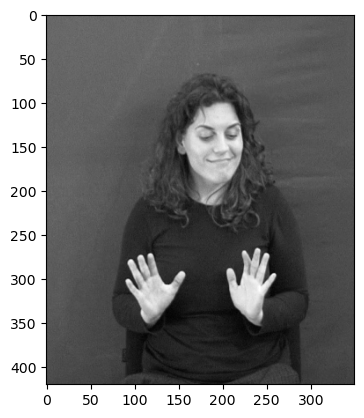

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (420, 350)
Range: 3 - 237 


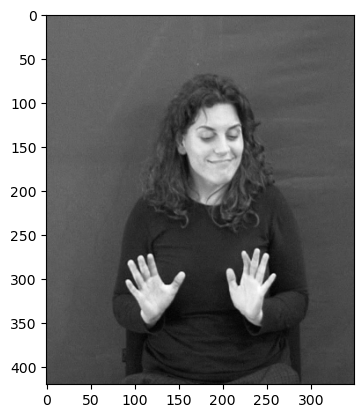

In [11]:
# 1st image

grayIm = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY)

print("Image loaded as: ", type(grayIm))
print("Resolution: ", grayIm.shape)
print("Range: %d - %d " % (np.min(grayIm), np.max(grayIm)))

# Normalize to [0,1]
grayIm = grayIm.astype(np.float32)/np.max(grayIm) # we need float32 type for "goodFeaturesToTrack" to work

plt.imshow(grayIm, cmap='gray')
plt.show()

# 2nd image

Im2 = cv2.imread(".\\cv23_lab2_material\\part1 - GreekSignLanguage\\2.png")
grayIm2 = cv2.cvtColor(Im2, cv2.COLOR_BGR2GRAY)

print("Image loaded as: ", type(grayIm2))
print("Resolution: ", grayIm2.shape)
print("Range: %d - %d " % (np.min(grayIm2), np.max(grayIm2)))

# Normalize to [0,1]

grayIm2 = grayIm2.astype(np.float32)/np.max(grayIm2)

plt.imshow(grayIm2, cmap='gray')
plt.show()

In [12]:
# setting up bounding boxes

face_1 = grayIm[102:(115+102), 154:(154+67)]
left_1 = grayIm[272:(83+272), 93:(93+56)]
right_1 = grayIm[270:(83+270), 201:(201+56)]

face_2 = grayIm2[102:(115+102), 154:(154+67)]  # face_2 = grayIm[102-1:(115+102-1), 154-1:(154+67-1)] is used for debugging    
left_2 = grayIm2[272:(83+272), 93:(93+56)]
right_2 = grayIm2[270:(83+270), 201:(201+56)]

# computing corners

corners = cv2.goodFeaturesToTrack(left_1, 1000, 0.1, 0.1)
corners = np.int0(corners)

print(corners.shape)

(25, 1, 2)


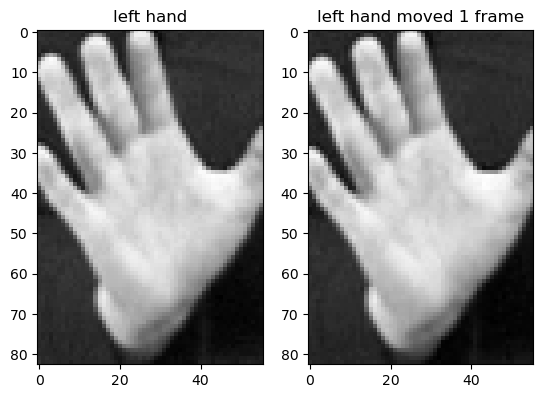

(-0.05514300584763987, 0.568979440300609)
The average of all d's is: [-0.09748361919831951, 0.48535176338395103]


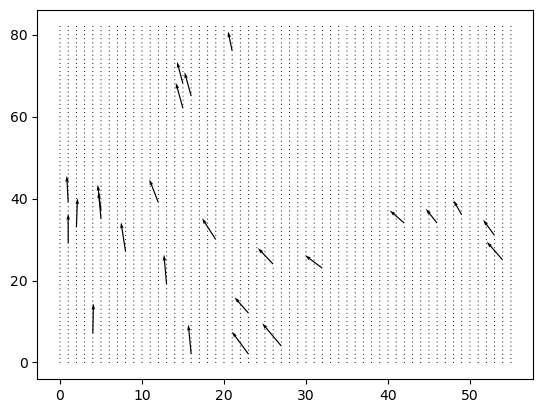

In [15]:
plt.subplot(1,2,1)
plt.imshow(left_1, cmap='gray')
plt.title("left hand")
plt.subplot(1,2,2)
plt.imshow(left_2, cmap='gray')
plt.title("left hand moved 1 frame")
plt.show()

# evaluating & visualizing optical flow using Lucas-Kanade method

# To initialize if you wish
dx_0 = np.zeros(left_1.shape)
dy_0 = np.zeros(left_1.shape)
for i in range(corners.shape[0]):
    x = corners[i][0][0]
    y = corners[i][0][1]
    dx_0[y][x] = 0
    dy_0[y][x] = 0
# dx_0[60][40] = 1
# dy_0[60][40] = 1

dx, dy = lk(left_1, left_2, corners, 5, 0.01, dx_0, dy_0) 

print(displ_lk(dx,dy))

print("The average of all d's is: [" + str(np.sum(dx)/corners.shape[0]) + ", " + str(np.sum(dy)/corners.shape[0]) + "]") 
# we print the average of d's in order to save space

plt.quiver(dx, dy, angles='xy', scale=10)
plt.show()

Σημειώσεις:

1) Η υλοποίησή μας δουλεύει καλά για μεγάλο "ρ" και μικρή σταθερά "ε". Περαιτέρω αύξηση του "ρ" άνω του 5 δε δίνει καλύτερα αποτελέσματα.

2) Η αρχική εκτίμηση για το διάνυσμα "d" μπορεί να είναι τυχαία. Τρέχοντας τον αλγόριθμο για 1η φορά, θα παρατηρήσουμε ότι έχουμε εν γένει μεγάλες αποκλίσεις σε κάποιες γωνίες. Το πρόβλημα αυτό λύνεται υπολογίζοντας τη μέση τιμή όλων των "d" και βάζοντας αυτή ως αρχική εκτίμηση τη 2η φορά που τρέχουμε τον αλγόριθμο. Τα αποτελέσματα που προκύπτουν είναι πολύ ικανοποιητικά.

The average optical flow is [-0.08210476  0.5208058 ]


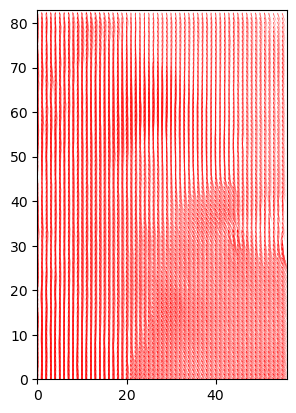

In [16]:
#computing & visualizing optical flow using TV-L1 from OpenCV

optical_flow = cv2.DualTVL1OpticalFlow_create()

flow = optical_flow.calc(left_1, left_2, None)

print("The average optical flow is", np.mean(np.mean(flow, axis=0), axis=0)) # we compare this with the average value of d's


flow_x = flow[..., 0]
flow_y = flow[..., 1]

h, w = flow.shape[:2]
x = np.arange(0, w, 1)
y = np.arange(0, h, 1)
x, y = np.meshgrid(x, y)

plt.quiver(x, y, flow_x, flow_y, color='r', angles='xy', scale_units='xy', scale=1, headaxislength=40, headlength=5)

plt.xlim([0, w])
plt.ylim([0, h])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

### 1.2.2

In [18]:
def displ_lk(dx,dy): 
    
    sum_of_squares = np.square(dx) + np.square(dy)
    
    winners = sum_of_squares > (np.sum(sum_of_squares)/len(np.nonzero(sum_of_squares)[0])) 
    # the average value is used as the threshold
    
    masked_sum_of_dx = np.where(winners, dx, np.zeros(winners.shape))
    masked_sum_of_dy = np.where(winners, dy, np.zeros(winners.shape))
    
    return ((np.sum(masked_sum_of_dx)/len(np.nonzero(masked_sum_of_dx)[0])) , (np.sum(masked_sum_of_dy)/len(np.nonzero(masked_sum_of_dy)[0])) )   

In [19]:
def displ_tvl1(d): 
    
    dx, dy = zip(*d)
    sum_of_squares = np.square(dx) + np.square(dy)
    
    winners = sum_of_squares > np.mean(sum_of_squares) # the average value is used as the threshold
    
    masked_sum_of_dx = np.ma.masked_array(dx, mask=~winners)
    masked_sum_of_dy = np.ma.masked_array(dy, mask=~winners)
    
    return (np.mean(dx), np.mean(dy))   

In [20]:
def optical_flow_tvL1(box_1, box_2): # we use this function to output optical flow in the same way as Lucas-Kanade method, so we
                                     # can use displ(d) function without modifying it 
    
    optical_flow = cv2.DualTVL1OpticalFlow_create()
    flow = optical_flow.calc(box_1, box_2, None)
    
    flow_x = flow[..., 0]
    flow_y = flow[..., 1]
    
    x_components = flow_x[..., 0] 
    y_components = flow_y[..., 1]

    return np.column_stack((x_components, y_components)).tolist()

In [21]:
def track(box, flag=True):  # flag indicates which method will be used for optical flow computation
    
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    dx, dy = [0,0]
    
    for i in range(1,70):
        
        
        filename_1 = ".\cv23_lab2_material\\part1 - GreekSignLanguage\{}.png".format(i)
        filename_2 = ".\cv23_lab2_material\\part1 - GreekSignLanguage\{}.png".format(i+1)
    
        Im = cv2.imread(filename_1)
        Im = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY)
        Im = Im.astype(np.float32)/np.max(Im)
        
        if(i == 1): # first bounding box
            
            plt.imshow(cv2.rectangle(Im, (x,y), (x+w,y+h), (0,0,255), 2), cmap = 'gray')
            print("Iteration no.", i)
            print("Coordinates of bounding box are (",x,",",y,")")
    
        box_1 = Im[y:(h+y), x:(x+w)]   
    
        Im2 = cv2.imread(filename_2)
        Im2 = cv2.cvtColor(Im2, cv2.COLOR_BGR2GRAY)
        Im2 = Im2.astype(np.float32)/np.max(Im2) 
    
        box_2 = Im2[y:(h+y), x:(x+w)]
    
        corners = cv2.goodFeaturesToTrack(box_1, 10, 0.1, 0.1) # peirazw times edw
        corners = np.int0(corners)
        
        #gia kapoio logo, me poly megalo rho trexei #(1,1) is arbitrary
        if(flag): dx, dy = lk(box_1, box_2, corners, 10, 0.005, np.zeros(box_1.shape),  np.zeros(box_1.shape)) 
        else: d = optical_flow_tvL1(box_1, box_2)
        
        if(flag): dx, dy = displ_lk(dx,dy)
        else: dx, dy = displ_tvl1(d)
    
        x, y = [round(x+dx), round(y+dy)]
    
        Im2 = cv2.rectangle(Im2, (x,y), (x+w,y+h), (0,0,255), 2)

        plt.imshow(Im2, cmap = 'gray')
        plt.show()
    
        print("Iteration no.", i+1)
        print("Coordinates of bounding box are (",x,",",y,")")


In [ ]:
#tracking using TV-L1 method for optical flow

left_hand = [93, 272, 56, 83]
right_hand = [201, 270, 56, 83]
face = [154, 102, 67, 115]

track(left_hand, False)

In [ ]:
# tracking using Lucas-Kanade method for optical flow

left_hand = [93, 272, 56, 83]  # gia to aristero xeri lagkarei meta thn 62h epanalhpsh...
right_hand = [201, 270, 56, 83]
face = [154, 102, 67, 115]


track(left_hand)

### 1.2.3

In [23]:
# Lowpass filter

def Lowpass_Filter(a): # a = 0.6 is good for gauss pyramid generation
    k = np.zeros((5,1))
    k[2] = a
    k[1] = k[3] = 1/4
    k[0] = k[4] = 1/4 - a/2
    return k @ k.T

In [24]:
def GREDUCE(Im,h):
    
    # Performing Lowpass filtering with kernel h and decimation 
    Im_filtered = cv2.filter2D(Im, -1, h)
    
    g = cv2.pyrDown(Im_filtered)
    
    return g


In [25]:
def GPyramid(Im, a, depth):
    h = Lowpass_Filter(a)
    G = []

    G.append(Im) # G[0] is the original image

    for level in range(depth):
        G.append(GREDUCE(G[level],h))

    return G

In [26]:
def multiscale_lk(I1, I2, rho, epsilon, depth):
    # Generate Pyramids
    G1 = GPyramid(I1, 0.6, depth)
    G2 = GPyramid(I2, 0.6, depth)
    
    I1 = G1.pop() # pop first pyramid level
    I2 = G2.pop()
    dx = np.zeros(I1.shape) # init
    dy = np.zeros(I1.shape)
    for i in range(depth):
        corners = cv2.goodFeaturesToTrack(I1, 1000, 0.1, 0.1) 
        corners = np.int0(corners)
        dx, dy = lk(I1, I2, corners, 10, 0.005, dx,  dy)
        dx = 2*dx
        dy = 2*dy
        dx = cv2.pyrUp(dx)
        dy = cv2.pyrUp(dy)
        I1 = G1.pop()
        I2 = G2.pop()
        
    corners = cv2.goodFeaturesToTrack(I1, 1000, 0.1, 0.1) 
    corners = np.int0(corners)
    dx, dy = lk(I1, I2, corners, 10, 0.005, dx,  dy)
        
    return dx, dy

In [27]:
print(left_1.shape)

(83, 56)


(-0.03941201413503504, 0.2142545671622824)
The average of all d's is: [-0.014388516578776052, 0.07867395263135685]


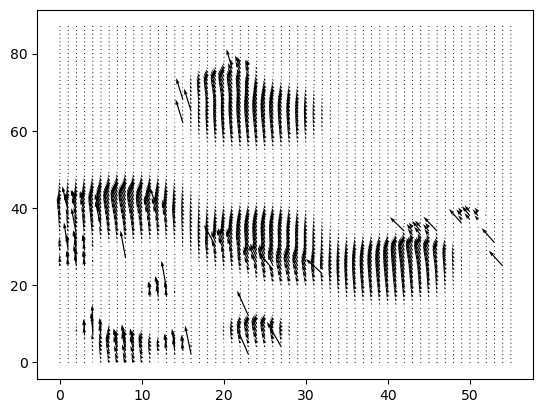

In [28]:
# evaluating & visualizing optical flow using Lucas-Kanade method

dx, dy = multiscale_lk(left_1, left_2, 5, 0.01, 3)

print(displ_lk(dx,dy))

print("The average of all d's is: [" + str(np.sum(dx)/len(np.nonzero(dx)[0])) + ", " + str(np.sum(dy)/len(np.nonzero(dy)[0])) + "]") 
# we print the average of d's in order to save space

plt.quiver(dx, dy, angles='xy', scale=10)
plt.show()

In [29]:
def track_v2(box):  
    
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    dx, dy = [0,0]
    
    for i in range(1,70):
        
        
        filename_1 = ".\cv23_lab2_material\\part1 - GreekSignLanguage\{}.png".format(i)
        filename_2 = ".\cv23_lab2_material\\part1 - GreekSignLanguage\{}.png".format(i+1)
    
        Im = cv2.imread(filename_1)
        Im = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY)
        Im = Im.astype(np.float32)/np.max(Im)
        
        if(i==1):
            
            plt.imshow(cv2.rectangle(Im, (x,y), (x+w,y+h), (0,0,255), 2), cmap = 'gray')
            print("Iteration no.", i)
            print("Coordinates of bounding box are (",x,",",y,")")
    
        box_1 = Im[y:(h+y), x:(x+w)]   
    
        Im2 = cv2.imread(filename_2)
        Im2 = cv2.cvtColor(Im2, cv2.COLOR_BGR2GRAY)
        Im2 = Im2.astype(np.float32)/np.max(Im2) 
    
        box_2 = Im2[y:(h+y), x:(x+w)]

        dx, dy = multiscale_lk(box_1, box_2, 10, 0.005, 2) 
    
        dx, dy = displ_lk(dx, dy)
    
        x, y = [round(x+dx), round(y+dy)]
    
        Im2 = cv2.rectangle(Im2, (x,y), (x+w,y+h), (0,0,255), 2)

    
        plt.imshow(Im2, cmap = 'gray')
        plt.show()
    
        print("Iteration no.", i+1)
        print("Coordinates of bounding box are (",x,",",y,")")


In [ ]:
# tracking using Lucas-Kanade multiscale method for optical flow

left_hand = [93, 272, 56, 83]  
right_hand = [201, 270, 56, 83]
face = [154, 102, 67, 115]

track_v2(left_hand)

## Part 2

2.1

In [29]:
# imports

import cv23_lab2_2_utils as p3
from scipy.ndimage import convolve1d


In [30]:
V = p3.read_video('./cv23_lab2_material/part2 - SpatioTemporal/handwaving/person01_handwaving_d2_uncomp.avi',200,0)

print("Video loaded as: ", type(V))

print("Resolution: ", V.shape)
print("Range: %d - %d " % (np.min(V), np.max(V)))

Video loaded as:  <class 'numpy.ndarray'>
Resolution:  (120, 160, 200)
Range: 0 - 241 


In [31]:
# Normalize to [0,1]
V = V.astype(float)/np.max(V)

print("Range: %f - %f " % (np.min(V), np.max(V)))

Range: 0.000000 - 1.000000 


In [5]:
## Harris-stephens detector 3D (x,y,t)

def Harris_Stephens(V, sigma, tau, s, theta_corn, k):
    n1 = int(np.ceil(3 * sigma) * 2 + 1)
    Gaussian_sigma = cv2.getGaussianKernel(n1, sigma)
    Gaussian_sigma = Gaussian_sigma.reshape(Gaussian_sigma.shape[0])
    
    n2 = int(np.ceil(3 * tau) * 2 + 1)
    Gaussian_tau = cv2.getGaussianKernel(n2, tau)
    Gaussian_tau = Gaussian_tau.reshape(Gaussian_tau.shape[0])
    
    I_gaussblur_3D = convolve1d(convolve1d(convolve1d(V,Gaussian_sigma,axis=0),Gaussian_sigma,axis=1),Gaussian_tau,axis=2)
    
    Lx, Ly, Lt = np.gradient(I_gaussblur_3D)
    
    n1 = int(np.ceil(3 * s*sigma) * 2 + 1)
    Gaussian_sigma_s = cv2.getGaussianKernel(n1, s*sigma)
    Gaussian_sigma_s = Gaussian_sigma_s.reshape(Gaussian_sigma_s.shape[0])
    
    n2 = int(np.ceil(3 * s*tau) * 2 + 1)
    Gaussian_tau_s = cv2.getGaussianKernel(n2, s*tau)
    Gaussian_tau_s = Gaussian_tau_s.reshape(Gaussian_tau_s.shape[0])
    
    M_1_1 = convolve1d(convolve1d(convolve1d(Lx**2,Gaussian_sigma_s,axis=0),Gaussian_sigma_s,axis=1),Gaussian_tau_s,axis=2)
    M_2_2 = convolve1d(convolve1d(convolve1d(Ly**2,Gaussian_sigma_s,axis=0),Gaussian_sigma_s,axis=1),Gaussian_tau_s,axis=2)
    M_3_3 = convolve1d(convolve1d(convolve1d(Lt**2,Gaussian_sigma_s,axis=0),Gaussian_sigma_s,axis=1),Gaussian_tau_s,axis=2)
    M_2_1 = convolve1d(convolve1d(convolve1d(Lx*Ly,Gaussian_sigma_s,axis=0),Gaussian_sigma_s,axis=1),Gaussian_tau_s,axis=2)
    M_3_1 = convolve1d(convolve1d(convolve1d(Lx*Lt,Gaussian_sigma_s,axis=0),Gaussian_sigma_s,axis=1),Gaussian_tau_s,axis=2)
    M_3_2 = convolve1d(convolve1d(convolve1d(Ly*Lt,Gaussian_sigma_s,axis=0),Gaussian_sigma_s,axis=1),Gaussian_tau_s,axis=2)
    
    trace = M_1_1 + M_2_2 + M_3_3
    det = M_1_1*M_2_2*M_3_3 + 2*M_2_1*M_3_1*M_3_2 - M_1_1*M_3_2**2 - M_2_2*M_3_1**2 - M_3_3*M_2_1**2

    H = det - k*trace**3
    
    # Synthikh = H > theta_corn*np.maximum(H) !!! not needed
    
    ind_y, ind_x, ind_t = np.unravel_index(np.argsort(-1*H, axis=None), H.shape)
    
    scale = sigma*np.ones(ind_x.shape)
    
    Interest_points = list(zip(ind_x,ind_y,ind_t,scale))
    
    return np.asarray(Interest_points[:500])
    
    
Interest_points = Harris_Stephens(V, 4, 1.5, 2, 0.05, 0.005)

In [13]:
# Visualize
%matplotlib inline

p3.show_detection(V,Interest_points, save_path = './Harris_outputs/handwaving')

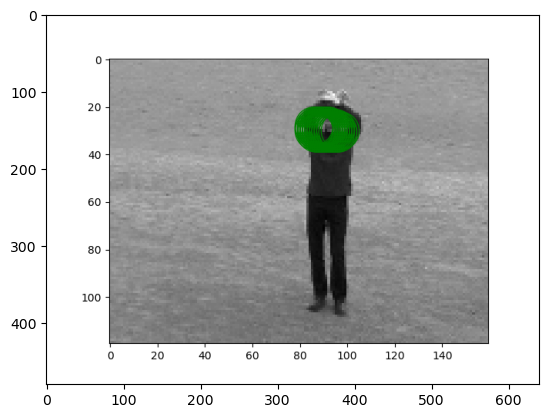

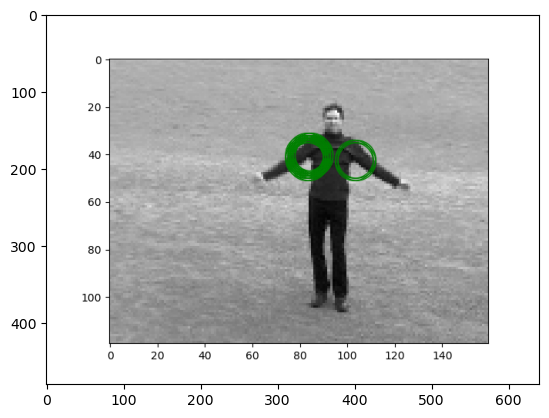

In [14]:
%matplotlib inline

Frame_1 = cv2.imread("./Harris_outputs/handwaving/frame66.png")
Frame_2 = cv2.imread("./Harris_outputs/handwaving/frame86.png")

plt.imshow(Frame_1)
plt.show()

plt.imshow(Frame_2)
plt.show()

In [17]:
## Gabor detector 3D (x,y,t)

def Gabor(V, sigma, tau, theta_corn):
    n1 = int(np.ceil(3 * sigma) * 2 + 1)
    Gaussian_sigma = cv2.getGaussianKernel(n1, sigma)
    Gaussian_sigma = Gaussian_sigma.reshape(Gaussian_sigma.shape[0])
    
    omega = 4.0/tau
    t = np.linspace(-2*tau,2*tau,int(4*tau+1))
    
    Gabor_tau_ev = (np.cos(2*np.pi*t*omega)*np.exp(-t**2 / (2 * tau**2)))        
    Gabor_tau_od = (np.sin(2*np.pi*t*omega)*np.exp(-t**2 / (2 * tau**2)))
    
    Gabor_tau_ev = Gabor_tau_ev/np.linalg.norm(Gabor_tau_ev, ord=1)
    Gabor_tau_od = Gabor_tau_od/np.linalg.norm(Gabor_tau_od, ord=1)
    
    I_ev = convolve1d(convolve1d(convolve1d(V,Gaussian_sigma,axis=0),Gaussian_sigma,axis=1),Gabor_tau_ev,axis=2)
    
    I_od = convolve1d(convolve1d(convolve1d(V,Gaussian_sigma,axis=0),Gaussian_sigma,axis=1),Gabor_tau_od,axis=2)
    
    H = I_ev**2 + I_od**2
    
    # Synthikh = H > theta_corn*np.maximum(H) !!! not needed
    
    ind_y, ind_x, ind_t = np.unravel_index(np.argsort(-1*H, axis=None), H.shape)
    
    scale = sigma*np.ones(ind_x.shape)
    
    Interest_points = list(zip(ind_x,ind_y,ind_t,scale))
    
    return np.asarray(Interest_points[:500])
    
    
Interest_points = Gabor(V, 4, 1.5, 0.05)

In [18]:
# Visualize
%matplotlib inline

p3.show_detection(V,Interest_points, save_path = './Gabor_outputs/handwaving')

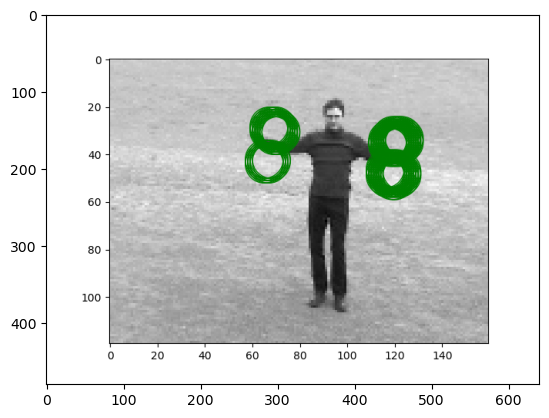

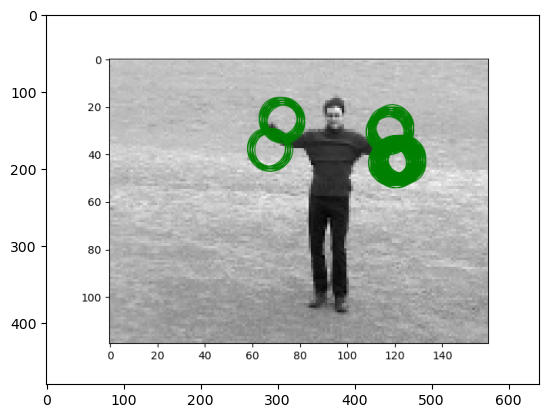

In [20]:
%matplotlib inline

Frame_1 = cv2.imread("./Gabor_outputs/handwaving/frame188.png")
Frame_2 = cv2.imread("./Gabor_outputs/handwaving/frame189.png")

plt.imshow(Frame_1)
plt.show()

plt.imshow(Frame_2)
plt.show()

2.2

In [53]:
def out_of_bounds(feature):
    sigma = feature[3]
    return ((feature[1] - sigma//2) < 0) or ((feature[1] + sigma//2) > 120) or ((feature[0] - sigma//2) < 0) or ((feature[0] + sigma//2) > 160)

In [74]:
# Time-spacial histogram descriptors

def hist_descriptor(V, features, descriptor, nbins):
    histdescription = []
    if (descriptor == 'HOG') or (descriptor == 'HOG/HOF'):
        
        Vx, Vy, Vt = np.gradient(V)
        
        for feature in list(features):
            # cut sigma * sigma
            if out_of_bounds(feature):
                print('kapsimo')
            else:
                sigma = int(feature[3])
                Gx = Vx[int(feature[1]-sigma//2):int(feature[1]+sigma//2),int(feature[0]-sigma//2):int(feature[0]+sigma//2),int(feature[2])]
                Gy = Vy[int(feature[1]-sigma//2):int(feature[1]+sigma//2),int(feature[0]-sigma//2):int(feature[0]+sigma//2),int(feature[2])]
                
                desc = p3.orientation_histogram(Gx,Gy,nbins,np.array([sigma,sigma]))
                histdescription.append(desc)
        
    if (descriptor == 'HOF') or (descriptor == 'HOG/HOF'):
        
        Flow_x = []
        Flow_y = []
        for i in range(V.shape[2] - 1):
            
            temp = V[:,:,i]*241
            epomeno = V[:,:,i+1]*241
            optical_flow = cv2.DualTVL1OpticalFlow_create()
            flow = optical_flow.calc(temp.astype('uint8'), epomeno.astype('uint8'), None)
            
            flow_x = flow[..., 0]
            flow_y = flow[..., 1]
                        
            Flow_x.append(flow_x)
            Flow_y.append(flow_y)
            
        for feature in list(features):
            # cut sigma * sigma
            if out_of_bounds(feature):
                print('kapsimo')
            else:
                sigma = int(feature[3])
                Gx = Flow_x[int(feature[2])][int(feature[1]-sigma//2):int(feature[1]+sigma//2),int(feature[0]-sigma//2):int(feature[0]+sigma//2)]
                Gy = Flow_y[int(feature[2])][int(feature[1]-sigma//2):int(feature[1]+sigma//2),int(feature[0]-sigma//2):int(feature[0]+sigma//2)]
                
                desc = p3.orientation_histogram(Gx,Gy,nbins,np.array([sigma,sigma]))
                histdescription.append(desc)
        
    return histdescription    
        
        
# HOG = hist_descriptor(V, Interest_points, 'HOG', 8)
# HOF = hist_descriptor(V, Interest_points, 'HOF', 8)
# HOG_HOF = hist_descriptor(V, Interest_points, 'HOG/HOF', 8)

In [57]:
print(np.asarray(HOG).shape)
print(np.asarray(HOF).shape)
print(np.asarray(HOG_HOF).shape)
print(4*4*8)

(500, 128)
(500, 128)
(1000, 128)
128


2.3

In [71]:
training_set = []
testing_set = []

i = 0
with open('./cv23_lab2_material/part2 - SpatioTemporal/traininng_videos.txt') as file:
        # reading each line   
        for video in file:
            if (i//12 == 0):
                training_set.append(p3.read_video('./cv23_lab2_material/part2 - SpatioTemporal/running/{}'.format(video),200,0))
            elif (i//12 == 1):
                training_set.append(p3.read_video('./cv23_lab2_material/part2 - SpatioTemporal/handwaving/{}'.format(video),200,0))
            elif (i//12 == 2):
                training_set.append(p3.read_video('./cv23_lab2_material/part2 - SpatioTemporal/walking/{}'.format(video),200,0))
            i += 1
        
i = 0
with open('./cv23_lab2_material/part2 - SpatioTemporal/testing_videos.txt') as file:
        # reading each line   
        for video in file:
            if (i//4 == 0):
                testing_set.append(p3.read_video('./cv23_lab2_material/part2 - SpatioTemporal/running/{}'.format(video),200,0))
            elif (i//4 == 1):
                testing_set.append(p3.read_video('./cv23_lab2_material/part2 - SpatioTemporal/handwaving/{}'.format(video),200,0))
            elif (i//4 == 2):
                testing_set.append(p3.read_video('./cv23_lab2_material/part2 - SpatioTemporal/walking/{}'.format(video),200,0))
            i += 1

        
print(len(training_set))
print(len(testing_set))

print(training_set[0].shape)
print(testing_set[0].shape)

# Normalize to [0,1]
for i in range(len(training_set)):
    training_set[i] = training_set[i].astype(float)/np.max(training_set[i])

for i in range(len(testing_set)):
    testing_set[i] = testing_set[i].astype(float)/np.max(testing_set[i])
    
print("Range: %f - %f " % (np.min(training_set[0]), np.max(training_set[0])))
print("Range: %f - %f " % (np.min(testing_set[0]), np.max(testing_set[0])))

36
12
(120, 160, 200)
(120, 160, 200)
Range: 0.038462 - 1.000000 
Range: 0.088710 - 1.000000 


In [75]:
import cv23_lab1_part3_utils as p1

training_set_desc = []
testing_set_desc = []

for V in training_set:
    Interest_points = Harris_Stephens(V, 4, 1.5, 2, 0.05, 0.005)
    training_set_desc.append(hist_descriptor(V, Interest_points, 'HOG', 8))
    
for V in testing_set:
    Interest_points = Harris_Stephens(V, 4, 1.5, 2, 0.05, 0.005)
    testing_set_desc.append(hist_descriptor(V, Interest_points, 'HOG', 8))
    
bow_train, bow_test = p1.BagOfWords(training_set_desc, testing_set_desc)


kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo


kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo
kapsimo


In [76]:
print(bow_train.shape)
print(bow_test.shape)

(36, 500)
(12, 500)
